In [91]:
import pandas as pd
import matplotlib.pyplot as plt

In [92]:
def load_and_plot_csv(filename):
    df = pd.read_csv(filename)
    # print(df.head())
    
    def filter_outliers(df, column_name):
        u_values = df[column_name].apply(lambda x: eval(x)[0])
        v_values = df[column_name].apply(lambda x: eval(x)[1])

        u_mean = u_values.mean()
        v_mean = v_values.mean()

        u_filtered = u_values[(u_values >= u_mean * 0.5) & (u_values <= u_mean * 1.5)]
        v_filtered = v_values[(v_values >= v_mean * 0.5) & (v_values <= v_mean * 1.5)]

        valid_rows = df[u_values.isin(u_filtered) & v_values.isin(v_filtered)]
        return valid_rows
    
    time = pd.Series([i * (10 / (len(df) - 1)) for i in range(len(df))])
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))
    
    for i, col in enumerate(['UV Hook', 'UV Tip', 'UV Lowpoint']):
        u_values = df[col].apply(lambda x: eval(x)[0])
        v_values = df[col].apply(lambda x: eval(x)[1])
        
        axes[i, 0].plot(time, u_values, label=f'u {col}', color='b')
        axes[i, 1].plot(time, v_values, label=f'v {col}', color='r')
        
        axes[i, 0].set_xlim(0, 10)
        axes[i, 1].set_xlim(0, 10)
        
        axes[i, 0].set_ylabel(f'u ({col})')
        axes[i, 1].set_ylabel(f'v ({col})')
        axes[i, 0].set_title(col)
        
        axes[i, 0].grid(True)
        axes[i, 1].grid(True)
        axes[i, 0].legend()
        axes[i, 1].legend()
    
    for ax in axes.flat:
        ax.set_xlabel('Time (s)')
    
    plt.tight_layout()
    plt.show()

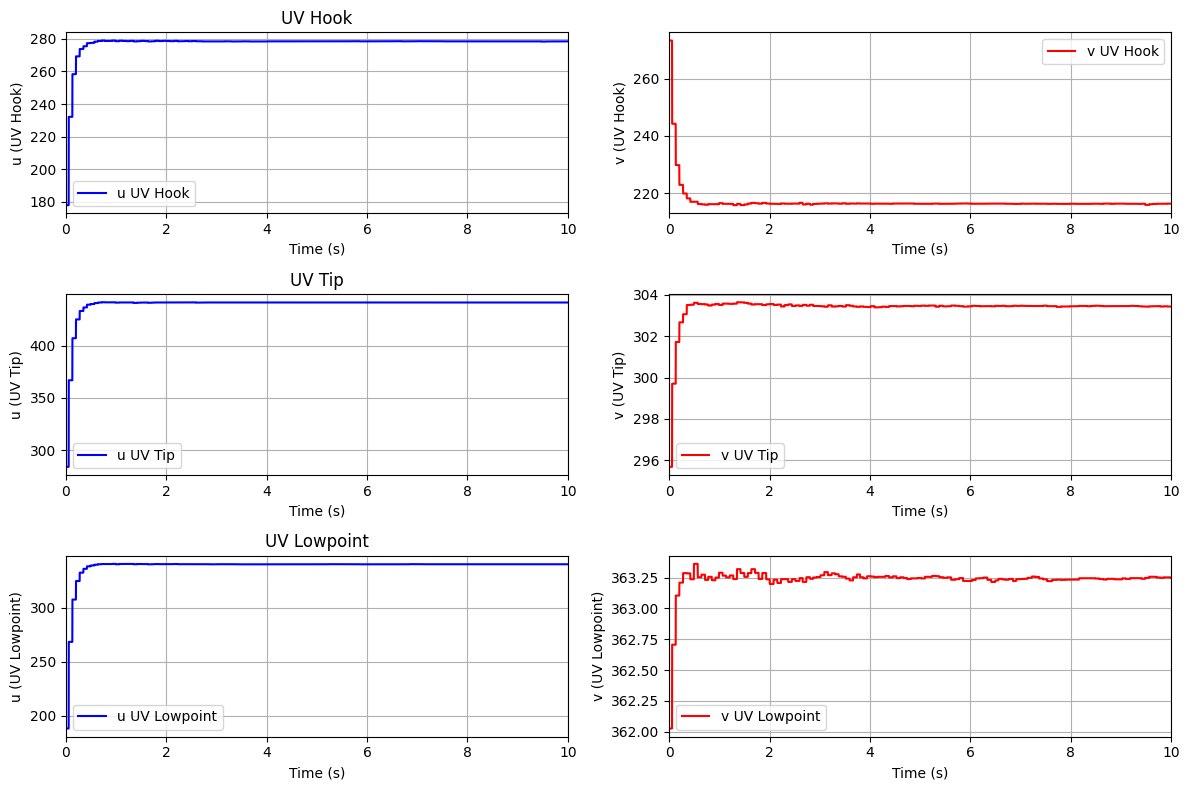

In [96]:
filename2 = '/home/mo/Thesis/src/robot_control/robot_control/vibration_measurement/vibration_measurement_2.csv'  # Ändere den Dateinamen nach Bedarf
load_and_plot_csv(filename2)

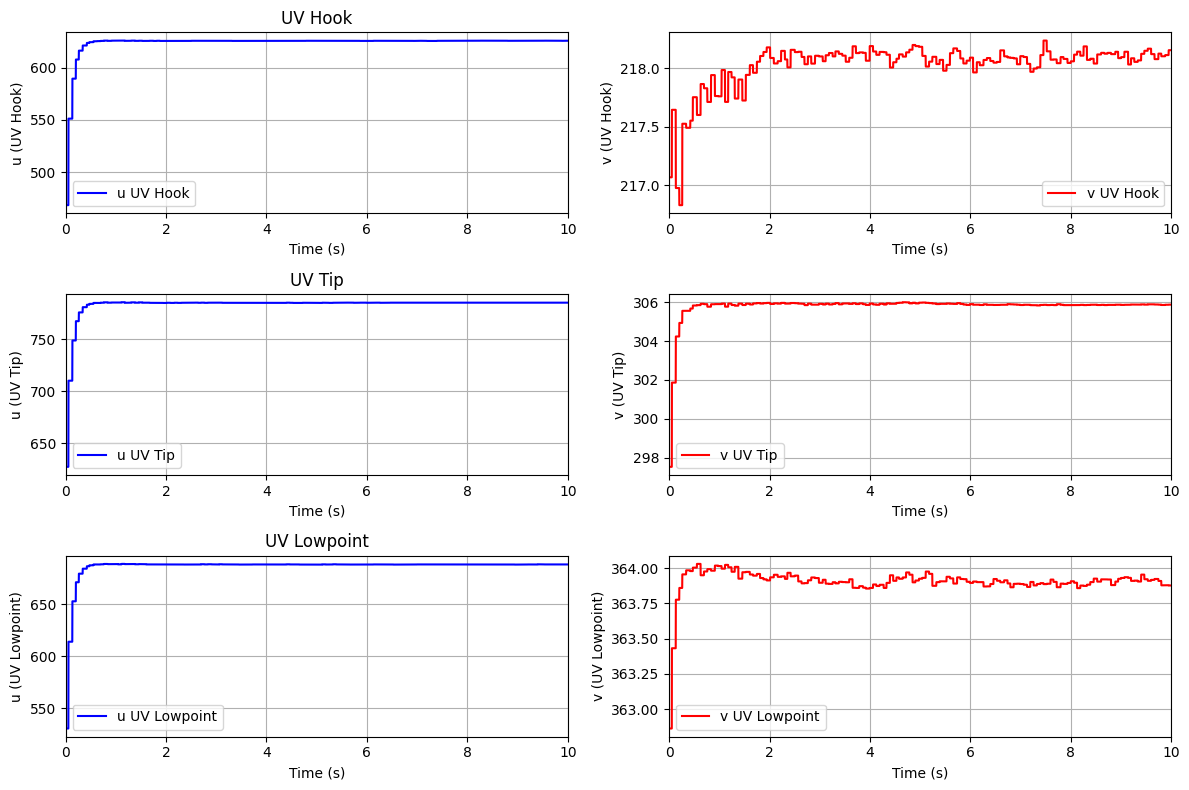

In [97]:
filename3 = '/home/mo/Thesis/src/robot_control/robot_control/vibration_measurement/vibration_measurement_3.csv'  # Ändere den Dateinamen nach Bedarf
load_and_plot_csv(filename3)

In [98]:
def load_and_plot_csv_diff(file1, file2):
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    '''
    print("First file preview:")
    print(df1.head())
    print("Second file preview:")
    print(df2.head())
    '''
    # Sicherstellen, dass beide DataFrames die gleiche Anzahl an Zeilen haben
    min_len = min(len(df1), len(df2))
    df1 = df1.iloc[:min_len].reset_index(drop=True)
    df2 = df2.iloc[:min_len].reset_index(drop=True)
    
    def compute_difference(df1, df2, column_name):
        u_diff = df1[column_name].apply(lambda x: eval(x)[0]) - df2[column_name].apply(lambda x: eval(x)[0])
        v_diff = df1[column_name].apply(lambda x: eval(x)[1]) - df2[column_name].apply(lambda x: eval(x)[1])
        return u_diff, v_diff
    
    # Zeitachsen-Korrektur
    time_1 = pd.Series([i * (10 / (min_len - 1)) for i in range(min_len)])
    time_2 = time_1.copy()
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))
    
    for i, col in enumerate(['UV Hook', 'UV Tip', 'UV Lowpoint']):
        u_diff, v_diff = compute_difference(df1, df2, col)
        
        axes[i, 0].plot(time_1, u_diff, label=f'u Difference {col}', color='b')
        axes[i, 1].plot(time_2, v_diff, label=f'v Difference {col}', color='r')

        axes[i, 0].set_xlim(0, 10)
        axes[i, 1].set_xlim(0, 10)

        axes[i, 0].set_ylabel(f'u Diff ({col})')
        axes[i, 1].set_ylabel(f'v Diff ({col})')
        axes[i, 0].set_title(f'Difference {col}')
        
        axes[i, 0].grid(True)
        axes[i, 1].grid(True)
        axes[i, 0].legend()
        axes[i, 1].legend()
    
    for ax in axes.flat:
        ax.set_xlabel('Time (s)')
    
    plt.tight_layout()
    plt.show()
    plt.savefig("difference.png", dpi=300, bbox_inches='tight')

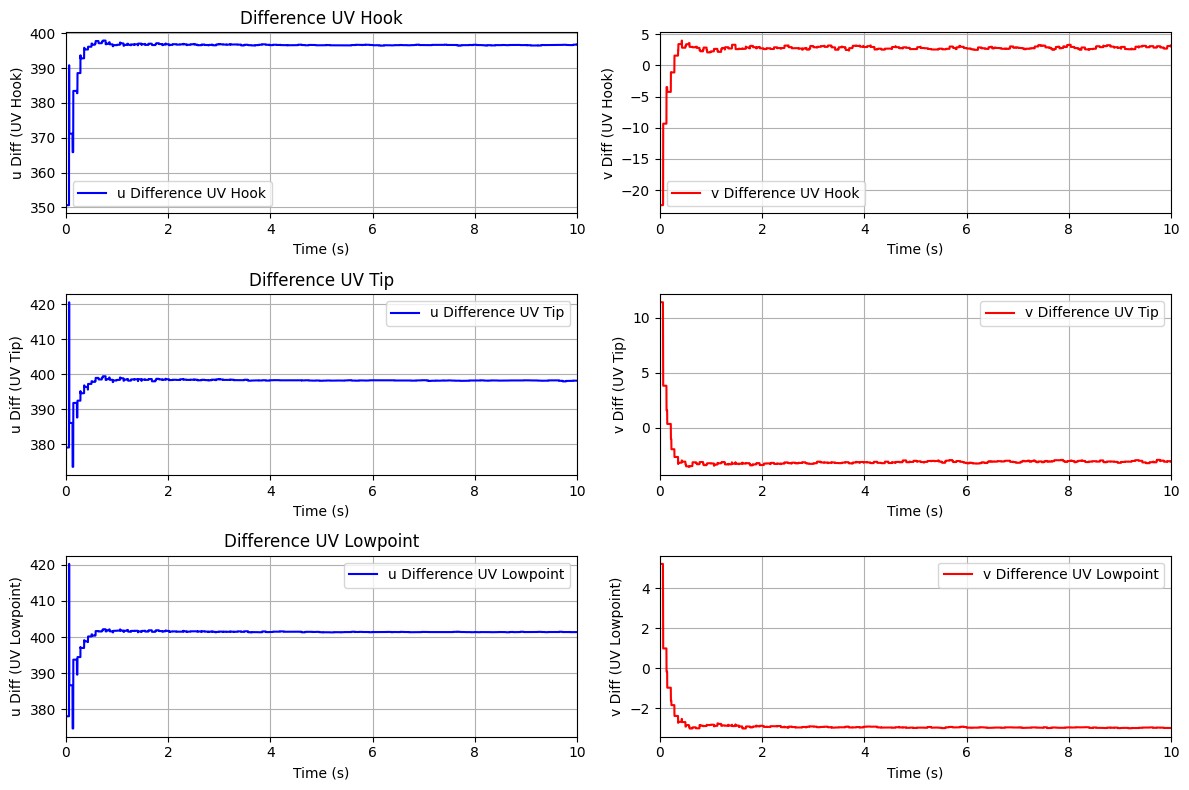

<Figure size 640x480 with 0 Axes>

In [124]:
load_and_plot_csv_diff(filename3, filename2)

***
# Filter

In [2]:
from collections import deque
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
class EMAFilter:
    def __init__(self, alpha: float, initial_value: float = 0.0):
        """
        Initialisiert den EMA-Filter.
        :param alpha: Glättungsfaktor (0 < alpha <= 1), je größer alpha, desto stärker das Gewicht neuer Werte.
        :param initial_value: Optionaler Startwert des Filters.
        """
        if not (0 < alpha <= 1):
            raise ValueError("Alpha muss im Bereich (0, 1] liegen.")
        
        self.alpha = alpha
        self.current_value = initial_value
        self.initialized = False

    def update(self, alpha_val, new_value: float) -> float:
        """
        Aktualisiert den EMA-Wert mit einem neuen Messwert.
        :param new_value: Der neue ungefilterte Wert.
        :return: Der aktuelle gefilterte Wert.
        """
        self.alpha = alpha_val
        
        if not self.initialized:
            self.current_value = new_value
            self.initialized = True
        else:
            self.current_value = self.alpha * new_value + (1 - self.alpha) * self.current_value
        
        return self.current_value
    
    def plot(self, values):
        """
        Plottet die gegebenen Werte.
        :param values: Liste von Werten, die geplottet werden sollen.
        """
        plt.figure(figsize=(10, 5))
        plt.plot(values[:, 0], values[:, 1], marker='o', linestyle='-')
        plt.title("EMA gefilterte Werte")
        plt.xlabel("Index")
        plt.ylabel("Wert")
        plt.grid()
        plt.show()

In [4]:
filter = EMAFilter(alpha = 1.0, initial_value = 0)

In [5]:
csv_filename = '/home/mo/Thesis/src/robot_control/robot_control/vibration_measurement/20mm_per_s/unfiltered/vibration_measurement_3.csv'
df1 = pd.read_csv(csv_filename)

In [6]:
def unpack(df, column_name):
    u_values = df[column_name].apply(lambda x: eval(x)[0])
    v_values = df[column_name].apply(lambda x: eval(x)[1])
    u_values = u_values.to_numpy()
    v_values = v_values.to_numpy()

    res = np.zeros(shape = (u_values.shape[0], 2))
    res[:, 0] = u_values
    res[:, 1] = v_values
    return res

In [7]:
uv_hook = unpack(df1, 'UV Hook')
uv_tip = unpack(df1, 'UV Tip')
uv_lowpoint = unpack(df1, 'UV Lowpoint')

In [8]:
def apply_filter(filter, alpha, nparray):
    v_filtered = []
    res = np.zeros(shape = (nparray.shape[0], nparray.shape[1]))

    for i in range(nparray.shape[0]):
        u = nparray[i, 0]
        v = nparray[i, 1]
        v_filtered.append(filter.update(new_value = v, alpha_val = alpha))
    
    res[:, 0] = u
    res[:, 1] = v_filtered
    return res

In [ ]:
uv_tip_filtered_08 = apply_filter(filter = filter, alpha = 0.8, nparray=uv_tip)
uv_tip_filtered_06 = apply_filter(filter = filter, alpha = 0.6, nparray=uv_tip)
uv_tip_filtered_04 = apply_filter(filter = filter, alpha = 0.4, nparray=uv_tip)
uv_tip_filtered_02 = apply_filter(filter = filter, alpha = 0.2, nparray=uv_tip)

In [81]:
def plot_two_arrays(array1=None, label1 = None,
                    array2=None, label2 = None,
                    array3=None, label3 = None,
                    array4=None, label4 = None,
                    array5=None, label5 = None,
                    title = 'Plot'):
    """
    Plottet bis zu fünf Arrays mit der Struktur (x, 2), wobei die erste Spalte x-Werte
    und die zweite Spalte y-Werte enthält. Die x-Achse wird auf den Bereich [0, 10] normiert.

    Args:
    array1, array2, array3, array4, array5: Numpy-Arrays der Form (n, 2), enthalten x und y-Werte.
    """
    plt.figure(figsize=(16, 8))
    
    def plot_array(array, label, color):
        if array is not None:
            x_scaled = np.linspace(0, 10, len(array))  # Erzeugt gleichmäßig verteilte x-Werte von 0 bis 10
            plt.plot(x_scaled, array[:, 1], label=label, color=color, linestyle='-')

    plot_array(array1, label1, 'black')
    plot_array(array2, label2, 'red')
    plot_array(array3, label3, 'green')
    plot_array(array4, label4, 'yellow')
    plot_array(array5, label5, 'blue')

    plt.legend()
    plt.xlabel('x-Achse (skaliert von 0 bis 10)')
    plt.ylabel('y-Achse')
    plt.title(title)
    plt.grid(True)
    plt.xlim(0, 10)  # Setzt die x-Achse explizit auf [0, 10]
    plt.ylim(305, 308)
    
    plt.show()

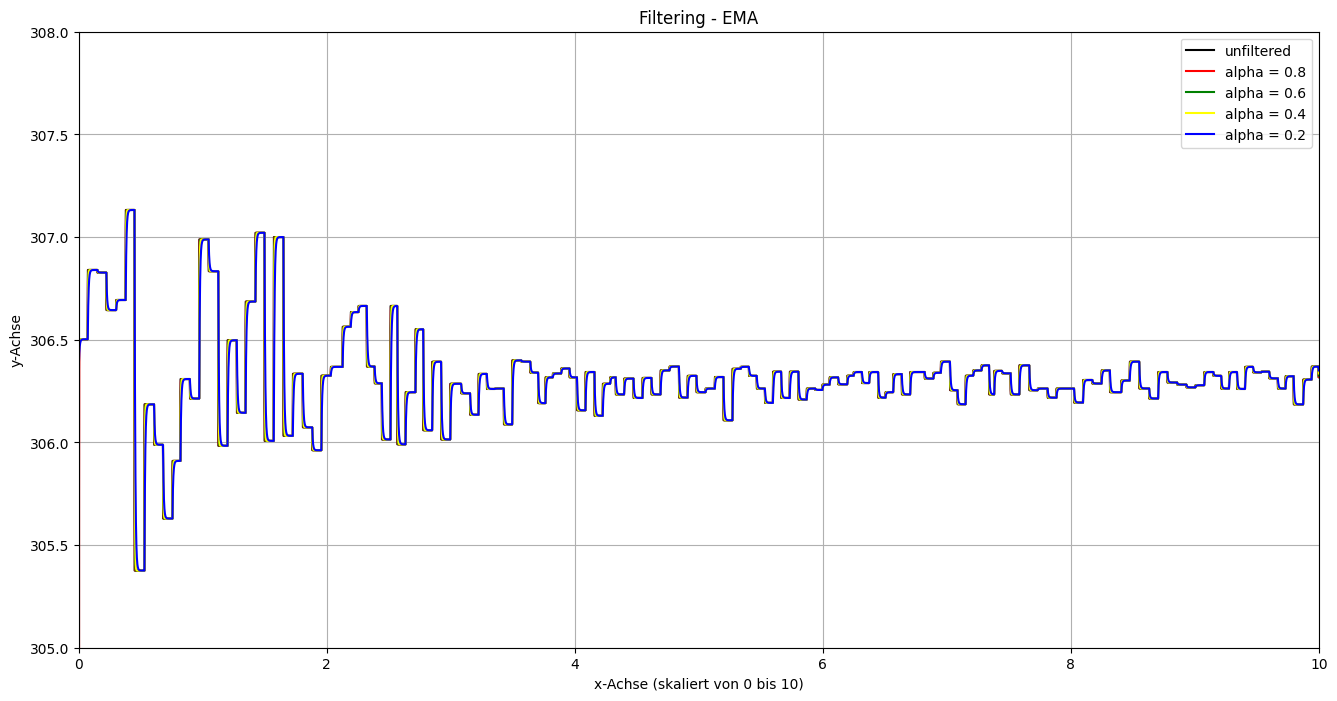

In [82]:
plot_two_arrays(array1 = uv_tip, label1 = 'unfiltered',
                array2 = uv_tip_filtered_08, label2 = 'alpha = 0.8',
                array3 = uv_tip_filtered_06, label3 = 'alpha = 0.6',
                array4 = uv_tip_filtered_04, label4 = 'alpha = 0.4',
                array5 = uv_tip_filtered_02, label5 = 'alpha = 0.2',
                title = 'Filtering - EMA')

In [83]:
class LowpassFilter:
    def __init__(self, f_g, T_s):
        self.f_g = f_g
        self.T_s = T_s
        self.T = 1 / ((2 / self.T_s) * np.tan((self.T_s * self.f_g) / 2))
        self.nyquist_shannon_okay = self.check_nyquist_shannon()

        self.prev_input = 0
        self.prev_output = 0
    
    def check_nyquist_shannon(self):
        if (1 / self.T_s) >= 2 * self.f_g:
            print("Lowpass Filter initialized correctly.")
            return True
        else:
            print("ERROR - Nyquist Shannon Theorem -> decrease sample time!!")
            return False
        
    def update(self, input_value):
        if self.nyquist_shannon_okay:
            K = 1 / (1 + 2 * self.T / self.T_s)
            y_k = K * (input_value + self.prev_input - (1 - 2 * self.T / self.T_s) * self.prev_output)
            self.prev_output = y_k
            self.prev_input = input_value
            return y_k

In [64]:
def apply_lowpass(filter, nparray):
    v_filtered = []
    res = np.zeros(shape=(nparray.shape[0], nparray.shape[1]))

    starttime = time.perf_counter()

    for i in range(nparray.shape[0]):
        v = nparray[i, 1]
        v_filtered.append(filter.update(input_value=v))
        
        # Wartezeit von 0.1 Sekunden
        time.sleep(0.001)

    res[:, 0] = nparray[:, 0]
    res[:, 1] = v_filtered
    return res

In [65]:
uv_tip_lowpass_5 = apply_lowpass(filter = LowpassFilter(f_g = 5, T_s = 0.001), nparray=uv_tip)
uv_tip_lowpass_10 = apply_lowpass(filter = LowpassFilter(f_g = 10, T_s = 0.001), nparray=uv_tip)
uv_tip_lowpass_20 = apply_lowpass(filter = LowpassFilter(f_g = 20, T_s = 0.001), nparray=uv_tip)
uv_tip_lowpass_50 = apply_lowpass(filter = LowpassFilter(f_g = 50, T_s = 0.001), nparray=uv_tip)
uv_tip_lowpass_100 = apply_lowpass(filter = LowpassFilter(f_g = 100, T_s = 0.001), nparray=uv_tip)

Lowpass Filter initialized correctly.
Lowpass Filter initialized correctly.
Lowpass Filter initialized correctly.
Lowpass Filter initialized correctly.
Lowpass Filter initialized correctly.


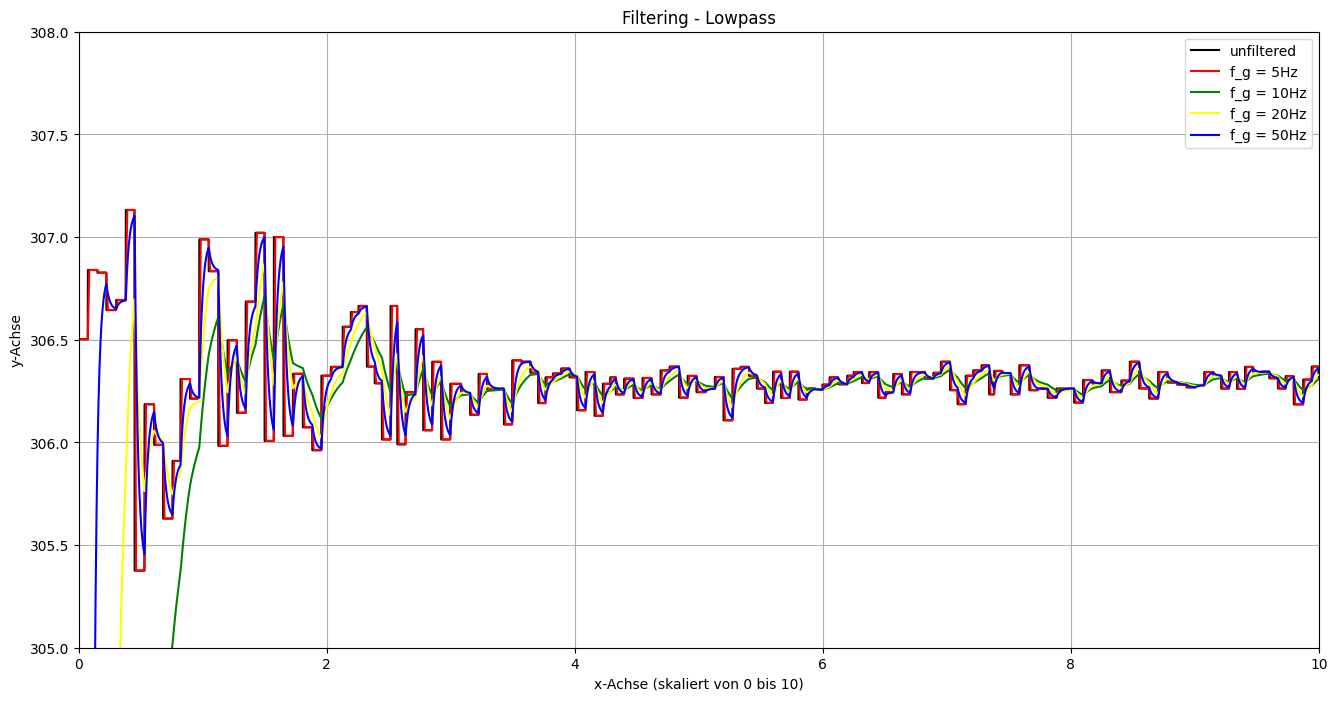

In [84]:
plot_two_arrays(array1 = uv_tip, label1 = 'unfiltered',
                array2 = uv_tip_lowpass_5, label2 = 'f_g = 5Hz',
                array3 = uv_tip_lowpass_10, label3 = 'f_g = 10Hz',
                array4 = uv_tip_lowpass_20, label4 = 'f_g = 20Hz',
                array5 = uv_tip_lowpass_50, label5 = 'f_g = 50Hz',
                title = 'Filtering - Lowpass')

In [85]:
class MovingAverageFilter:
    def __init__(self, window_size):
        """
        Erstellt einen gleitenden Mittelwertfilter mit einer bestimmten Fensterbreite.

        Args:
        window_size (int): Anzahl der Werte, über die der Mittelwert berechnet wird.
        """
        self.window_size = window_size
        self.buffer = []

    def update(self, input_value):
        """
        Aktualisiert den Filter mit einem neuen Eingangswert und gibt den gefilterten Wert zurück.

        Args:
        input_value (float): Neuer Eingangswert.

        Returns:
        float: Gefilterter Wert (Mittelwert über die letzten 'window_size' Werte).
        """
        self.buffer.append(input_value)
        if len(self.buffer) > self.window_size:
            self.buffer.pop(0)
        return np.mean(self.buffer)

In [86]:
def apply_movingavg(filter, nparray):
    v_filtered = []
    res = np.zeros(shape=(nparray.shape[0], nparray.shape[1]))

    starttime = time.perf_counter()

    for i in range(nparray.shape[0]):
        v = nparray[i, 1]
        v_filtered.append(filter.update(input_value=v))
    
    res[:, 0] = nparray[:, 0]
    res[:, 1] = v_filtered
    return res

In [87]:
uv_tip_movingavg_5 = apply_movingavg(filter = MovingAverageFilter(window_size = 10), nparray = uv_tip)
uv_tip_movingavg_10 = apply_movingavg(filter = MovingAverageFilter(window_size = 50), nparray = uv_tip)
uv_tip_movingavg_20 = apply_movingavg(filter = MovingAverageFilter(window_size = 100), nparray = uv_tip)
uv_tip_movingavg_50 = apply_movingavg(filter = MovingAverageFilter(window_size = 300), nparray = uv_tip)

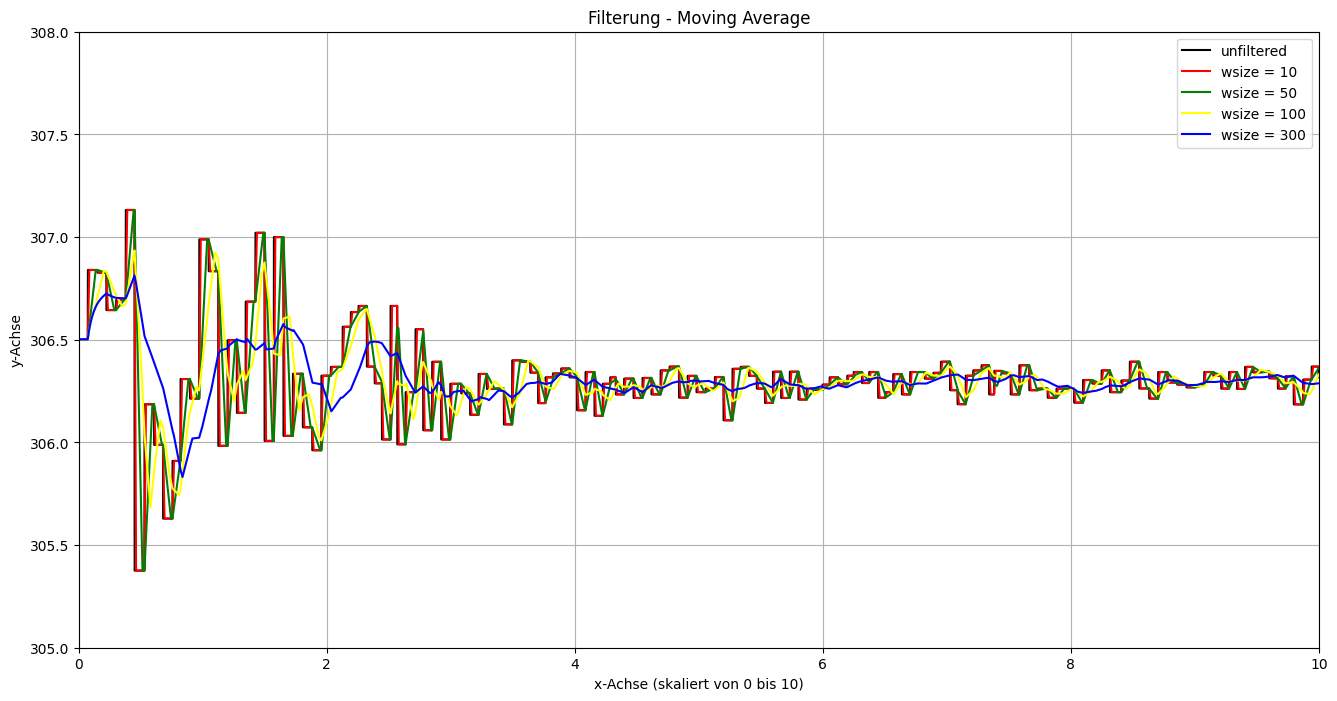

In [90]:
plot_two_arrays(array1 = uv_tip, label1 = 'unfiltered',
                array2 = uv_tip_movingavg_5, label2 = 'wsize = 10',
                array3 = uv_tip_movingavg_10, label3 = 'wsize = 50',
                array4 = uv_tip_movingavg_20, label4 = 'wsize = 100',
                array5 = uv_tip_movingavg_50, label5 = 'wsize = 300',
                title = 'Filterung - Moving Average')